In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from astropy.wcs import WCS
import numpy as np
from matplotlib.ticker import MultipleLocator
from scipy.stats import linregress
from matplotlib.colors import LogNorm
import astropy.io.fits as fits
from reproject import reproject_from_healpix
from matplotlib import cm
from matplotlib.colors import Normalize 
from matplotlib import pyplot as plt, patches
from scipy.interpolate import interpn
from reproject import reproject_to_healpix
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astropy import units as units
import matplotlib.cm as cm
import sys
from importlib import reload
import astropy.units as u
import copy
from matplotlib.ticker import MultipleLocator, FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc

In [14]:
directory = '/srv/data/dva/dva_map_test_results/Anna/Apr8/'
dir_out = '/home/aordog/DVA_PLOTS/'
plot_name = 'DRAO_15m_600_1000_MHz'
plot_title = 'DRAO 15-m 600 - 1000 MHz'
basefilename = 'DVA_Apr9'

# Some functions:

In [3]:
def zero_moment(hdr,data,peakthresh,maxFD,RM_arr):
    
    dFD = hdr['CDELT2']
    print('Calculating zeroth moment...')    
    print('Max FD to include: ',maxFD)
    print('FD channel width: ',dFD)
    
    zero_mom_hdr = hdr.copy()    
    zero_mom_hdr['NAXIS'] = 1  
    del zero_mom_hdr['CRVAL2']
    del zero_mom_hdr['CTYPE2']
    del zero_mom_hdr['CRPIX2']
    del zero_mom_hdr['CDELT2']
    del zero_mom_hdr['CUNIT2']
    del zero_mom_hdr['NAXIS2']
    try:
        del zero_mom_hdr['LAMSQ0']
    except:
        pass
    
    numpix = data.shape[1]   
    zero_mom_data = np.empty(numpix)
       
    for i in range(0,numpix):
        if i==int(numpix/2):
            print('halfway')
        #wgood = np.where((data[:,i]>=peakthresh) & (data[:,i]>=0.15*peakPI_data[i]) & (abs(RM_arr)<=maxFD))
        wgood = np.where((data[:,i]>=peakthresh) & (abs(RM_arr)<=maxFD))
        if np.size(wgood) != 0:
            zero_mom_data[i] = dFD*np.sum(data[wgood,i])
        else:
            zero_mom_data[i] = np.nan      
    
    print('done')
    print('')
    return(zero_mom_data,zero_mom_hdr)

def first_moment(hdr,data,peakthresh,maxFD,RM_arr,zero_mom):
    
    dFD = hdr['CDELT2']
    print('Calculating first moment...')    
    print('Max FD to include: ',maxFD)
    print('FD channel width: ',dFD)
    
    first_mom_hdr = hdr.copy()    
    first_mom_hdr['NAXIS'] = 1  
    del first_mom_hdr['CRVAL2']
    del first_mom_hdr['CTYPE2']
    del first_mom_hdr['CRPIX2']
    del first_mom_hdr['CDELT2']
    del first_mom_hdr['CUNIT2']
    del first_mom_hdr['NAXIS2']
    try:
        del zero_mom_hdr['LAMSQ0']
    except:
        pass
    
    numpix = data.shape[1]   
    first_mom_data = np.empty(numpix)
       
    for i in range(0,numpix):
        if i==int(numpix/2):
            print('halfway')
        #wgood = np.where((data[:,i]>=peakthresh) & (data[:,i]>=0.15*peakPI_data[i]) & (abs(RM_arr)<=maxFD))
        wgood = np.where((data[:,i]>=peakthresh) & (abs(RM_arr)<=maxFD))
        if np.size(wgood) != 0:
            first_mom_data[i] = dFD*np.sum(data[wgood,i]*RM_arr[wgood])/zero_mom[i]
        else:
            first_mom_data[i] = np.nan      
    
    print('done')
    print('')
    return(first_mom_data,first_mom_hdr)

class nice_map_zoom(object):
       
    def mollweide(data,coordsys,Pmin,Pmax,pixsize=0.5,fs=14,cmap=cm.viridis,title='',bg_clr='gray',
               xc=180,yc=0,grid_clr='black',lbl_clr='black',axtitles=True,cbarlbl='',lonra=[-180,180],latra=[-90,90],
               *args, **kwargs):
        print('Mollweide')
        proj = '-MOL'
        fc = 'EllipticalFrame'
        hdr_new,cs,ny,nx = make_new_header_zoom(coordsys,proj,pixsize,xc,yc,lonra)
        make_the_map_zoom(data,hdr_new,fc,cs,Pmin,Pmax,fs,cmap,title,bg_clr,grid_clr,lbl_clr,axtitles,cbarlbl,proj,latra,ny,nx)
        return
    
    def platcar(data,coordsys,Pmin,Pmax,pixsize=0.5,fs=14,cmap=cm.viridis,title='',bg_clr='gray',
               xc=180,yc=0,grid_clr='black',lbl_clr='black',axtitles=True,cbarlbl='',lonra=[-180,180],latra=[-90,90],
               *args, **kwargs):
        print('Plate Caree')
        proj = '-CAR'
        fc = 'Rect'
        hdr_new,cs,ny,nx = make_new_header_zoom(coordsys,proj,pixsize,xc,yc,lonra)
        make_the_map_zoom(data,hdr_new,fc,cs,Pmin,Pmax,fs,cmap,title,bg_clr,grid_clr,lbl_clr,axtitles,cbarlbl,proj,latra,ny,nx)
        return

def make_new_header_zoom(coordsys,proj,pixsize,xc,yc,lonra):
    if coordsys == 'C':
        ctype1 = 'RA--'+proj
        ctype2 = 'DEC-'+proj
        cs = 'icrs'
    if coordsys == 'G':
        ctype1 = 'GLON'+proj
        ctype2 = 'GLAT'+proj
        cs = 'galactic'

    if (proj == '-MOL') or (proj == '-AIT'):
        nx = int(round((((lonra[1]-lonra[0])/360)*4*np.sqrt(2)*180/(pixsize*np.pi)),0))
        ny = int(round((2*np.sqrt(2)*180/(pixsize*np.pi)),0))
    if (proj == '-CAR'):
        nx = int(round(((lonra[1]-lonra[0])/360)*(360/pixsize),0))
        ny = int(round((180/pixsize),0))
    if (proj == '-TAN'):
        nx = int(round((15*180/(pixsize*np.pi)),0))
        ny = int(round((15*180/(pixsize*np.pi)),0))

    hdr_new = fits.Header.fromstring("""
NAXIS   =                    2
CUNIT1  = 'deg     '
CUNIT2  = 'deg     '
COORDSYS= 'icrs    '
""", sep='\n')
    hdr_new['NAXIS1']  = nx 
    hdr_new['NAXIS2']  = ny
    hdr_new['CTYPE1']  = ctype1
    hdr_new['CRPIX1']  = nx/2.+0.5 
    hdr_new['CRVAL1']  = xc          
    hdr_new['CDELT1']  = -pixsize 
    hdr_new['CTYPE2']  = ctype2
    hdr_new['CRPIX2']  = ny/2.+0.5
    hdr_new['CRVAL2']  = yc
    hdr_new['CDELT2']  = pixsize
    #print(repr(hdr_new))    
    return(hdr_new,cs,ny,nx)    
    
    
def make_the_map_zoom(data,hdr_new,fc,cs,Pmin,Pmax,fs,cmap,title,bg_clr,
                 grid_clr,lbl_clr,axtitles,cbarlbl,proj,latra,ny,nx):

    array, footprint = reproject_from_healpix((data,cs),hdr_new, nested=False)
    
    fig = plt.figure(figsize=(15,10))
    
    srise = np.repeat(211.1,1000)
    sset = np.repeat(332.1,1000)
    dec_arr1 = np.linspace(14.7,86,1000)
    dec_arr2 = np.linspace(12,86,1000)

    c1 = SkyCoord(ra=srise*u.degree, dec=dec_arr1*u.degree, frame='icrs')
    c2 = SkyCoord(ra=sset*u.degree, dec=dec_arr2*u.degree, frame='icrs')

    c1_lon = c1.galactic.l.deg
    c1_lon[np.where(c1_lon >=180)] = c1_lon[np.where(c1_lon >=180)]-360.
    c1_lat = c1.galactic.b.deg
    c2_lon = c2.galactic.l.deg
    c2_lon[np.where(c2_lon >=180)] = c2_lon[np.where(c2_lon >=180)]-360.
    c2_lat = c2.galactic.b.deg
    
    
    if fc == 'EllipticalFrame':
        ax = plt.subplot(111, projection=WCS(hdr_new))
    else:
        ax = plt.subplot(111, projection=WCS(hdr_new))
                
    cmap.set_bad(color=bg_clr)
    im = ax.imshow(array, vmin=Pmin, vmax=Pmax,cmap=cmap)
    #ax.plot((360-c1_lon-120)*nx/240,(c1_lat+90.)*ny/180,color='black',linestyle='dashed')
    #ax.plot((360-c2_lon-120)*nx/240,(c2_lat+90.)*ny/180,color='black',linestyle='dashed')
    
    ax.coords.grid(color=grid_clr)
    ax.coords[0].set_ticklabel(color=lbl_clr,fontsize=fs)
    ax.coords[1].set_ticklabel(color=lbl_clr,fontsize=fs)
    ax.coords[0].set_ticks(number=5)
    ax.coords[1].set_ticks(number=5)
    ax.set_ylim((latra[0]+90)*ny/180,(latra[1]+90)*ny/180)
    #x_lim = ax.get_xlim()
    #y_lim = ax.get_ylim()
    #print(y_lim)
    #print(y_lim[0]*180/ny,y_lim[1]*180/ny)
    cbar = plt.colorbar(im,orientation='horizontal',shrink=0.4,pad=0.1)
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_label(cbarlbl,fontsize=fs)
    ax.set_title(title,fontsize=fs+2)
    if axtitles:
        if (proj == '-MOL') or (proj == '-AIT'):
            ypad = 1
        else:
            ypad = 1
        if cs == 'icrs':            
            ax.coords[0].set_axislabel('Right Ascension',fontsize=fs,minpad=ypad)
            #ax.coords[0].set_axislabel_position('t')
            ax.coords[1].set_axislabel('Declination',fontsize=fs)
        if cs == 'galactic':
            ax.coords[0].set_axislabel('Galactic Longitude',fontsize=fs,minpad=ypad)
            ax.coords[1].set_axislabel('Galactic Latitude',fontsize=fs)
    
    return


# 1 Run RM synthesis on FITS cubes

In [5]:
run_rm_synth = False

if run_rm_synth:
    !/home/ordoga/Python/RM-Tools/RMtools_3D/do_RMsynth_3D.py \
     /home/ordoga/DATA/DVA/combinedq.fits \
     /home/ordoga/DATA/DVA/combinedu.fits \
     /home/ordoga/DATA/DVA/ListOfFrequencies_Hz.txt -v -d 1 -l 200

# 2 Convert RM synth files to Healpix:

In [6]:
convert_to_hpx = True # Make this False if already have Healpix files


## 2.1 Read in RM synthesis files:

In [7]:
if convert_to_hpx:

    hdu_FDcube = fits.open(directory+'FDF_tot_dirty.fits')
    hdr_FDcube = hdu_FDcube[0].header
    data_FDcube = hdu_FDcube[0].data
    print(data_FDcube.shape)

    hdu_PIpeak = fits.open(directory+'FDF_maxPI.fits')
    hdr_PIpeak = hdu_PIpeak[0].header
    data_PIpeak = hdu_PIpeak[0].data[0]
    print(data_PIpeak.shape)

(401, 170, 360)
(170, 360)


## 2.2 Make new 2D header out of PI peak file

In [8]:
if convert_to_hpx:

    hdr_2D_new = hdr_PIpeak.copy()
    hdr_2D_new['NAXIS'] = 2
    del hdr_2D_new['NAXIS3']
    del hdr_2D_new['CTYPE3']
    del hdr_2D_new['CDELT3']
    del hdr_2D_new['CRVAL3']
    del hdr_2D_new['CUNIT3']
    del hdr_2D_new['CRPIX3']
    print(repr(hdr_2D_new))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  360                                                  
NAXIS2  =                  170                                                  
DATE    = '2023-04-08'         / Creation UTC (CCCC-MM-DD) date of FITS header  
TELESCOP= 'DRAO-15m'                                                            
CDELT1  =             -1.00000 /                                                
CRPIX1  =              180.000 /                                                
CRVAL1  =              180.000 /                                                
CTYPE1  = 'RA---CAR'           /                                                
CDELT2  =              1.00000 /                                                
CRPIX2  =              65.00

## 2.3 Reproject to healpix

In [9]:
if convert_to_hpx:

    nside = 128 # Note: smoothing a bit - original was nside=64 for now

    FDcube_hpx = np.empty([data_FDcube.shape[0],12*nside**2])

    for i in range(0,data_FDcube.shape[0]):
        print(i)    
        FDcube_hpx[i,:], footprint = reproject_to_healpix((data_FDcube[i,:,:], hdr_2D_new), 
                                                          'icrs', nside=nside)
    
    PIpeak_hpx, footprint = reproject_to_healpix((data_PIpeak, hdr_2D_new), 'icrs', nside=nside)

0
1
2


a floating-point value was expected. [astropy.wcs.wcs]


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


## 2.4 Write out new healpix files

In [10]:
if convert_to_hpx:
    
    hdu_new_hpx = fits.PrimaryHDU()
    hdr_hpx = hdu_new_hpx.header
    
    hdr_hpx['PIXTYPE'] = ('HEALPIX ', 'HEALPIX pixelisation')
    hdr_hpx['ORDERING'] = ('RING', 'Pixel ordering scheme, either RING or NESTED')
    hdr_hpx['NSIDE'] = (nside,     'Resolution parameter of HEALPIX')
    hdr_hpx['INDXSCHM'] = ('IMPLICIT', 'Indexing: IMPLICIT or EXPLICIT')
    hdr_hpx['OBJECT'] = ('FULLSKY ', 'Sky coverage, either FULLSKY or PARTIAL')
    hdr_hpx['COORDSYS'] = ('C', 'Ecliptic, Galactic or Celestial (equatorial)')
    hdr_hpx['NAXIS'] = 2
    hdr_hpx['NAXIS2'] = hdr_FDcube['NAXIS3']   
    hdr_hpx['CRPIX2'] = hdr_FDcube['CRPIX3']
    hdr_hpx['CDELT2'] = hdr_FDcube['CDELT3']
    hdr_hpx['CUNIT2'] = 'MHz'
    hdr_hpx['CTYPE2'] = 'FREQ'
    hdr_hpx['CRVAL2'] = hdr_FDcube['CRVAL3']

    hdr_hpx_1D = hdr_hpx.copy()
    hdr_hpx_1D['NAXIS'] = 1
    del hdr_hpx_1D['NAXIS2']
    del hdr_hpx_1D['CRPIX2']
    del hdr_hpx_1D['CDELT2']
    del hdr_hpx_1D['CTYPE2']
    del hdr_hpx_1D['CRVAL2']
    del hdr_hpx_1D['CUNIT2']
    
    print('')
    print('HEADER FOR FD CUBE')
    print('--------------')
    print(repr(hdr_hpx))
    print('')
    print('HEADER FOR PI PEAKS')
    print('---------------')
    print(repr(hdr_hpx_1D))
    
    fits.writeto(directory+basefilename+'_FDcube.hpx.fits',FDcube_hpx,
                 header=hdr_hpx,overwrite=True,output_verify='fix')
    
    fits.writeto(directory+basefilename+'_peakPI.hpx.fits',PIpeak_hpx,
                 header=hdr_hpx_1D,overwrite=True,output_verify='fix')


HEADER FOR FD CUBE
--------------
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
EXTEND  =                    T                                                  
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
NSIDE   =                  128 / Resolution parameter of HEALPIX                
INDXSCHM= 'IMPLICIT'           / Indexing: IMPLICIT or EXPLICIT                 
OBJECT  = 'FULLSKY '           / Sky coverage, either FULLSKY or PARTIAL        
COORDSYS= 'C       '           / Ecliptic, Galactic or Celestial (equatorial)   
NAXIS2  =                  401                                                  
CRPIX2  =                  201                                            

# 3 Work with Healpix FD files

## 3.1 Read in healpix files

In [15]:
hdu_FDcube_hpx = fits.open(directory+basefilename+'_FDcube.hpx.fits')
hdr_FDcube_hpx = hdu_FDcube_hpx[0].header
data_FDcube_hpx = hdu_FDcube_hpx[0].data
print(data_FDcube_hpx.shape)

hdu_PIpeak_hpx = fits.open(directory+basefilename+'_peakPI.hpx.fits')
hdr_PIpeak_hpx = hdu_PIpeak_hpx[0].header
data_PIpeak_hpx = hdu_PIpeak_hpx[0].data
print(data_PIpeak_hpx.shape)

FD_idx = np.linspace(0,hdr_FDcube_hpx['NAXIS2']-1,hdr_FDcube_hpx['NAXIS2'])
FD_ax = hdr_FDcube_hpx['CRVAL2']+(FD_idx - hdr_FDcube_hpx['CRPIX2']+1)*hdr_FDcube_hpx['CDELT2']

print(FD_ax.shape)

(401, 196608)
(196608,)
(401,)


## 3.2 Calculate Moments

In [16]:
maxabsFD = 60
minPI = 0

M0,M0_hdr = zero_moment(hdr_FDcube_hpx,data_FDcube_hpx,minPI,maxabsFD,FD_ax)
M1,M1_hdr = first_moment(hdr_FDcube_hpx,data_FDcube_hpx,minPI,maxabsFD,FD_ax,M0)

Calculating zeroth moment...
Max FD to include:  60
FD channel width:  1.0
halfway
done

Calculating first moment...
Max FD to include:  60
FD channel width:  1.0


<ipython-input-3-27a66e8bb027>:67: RuntimeWarning: invalid value encountered in double_scalars
  first_mom_data[i] = dFD*np.sum(data[wgood,i]*RM_arr[wgood])/zero_mom[i]


halfway
done



## 3.3 Convert moment maps to Galactic

In [17]:
import healpy
r = healpy.rotator.Rotator(coord=['C','G'])
M0_gal = r.rotate_map_pixel(M0)
M1_gal = r.rotate_map_pixel(M1)

## 3.4 Make M1 map

Plate Caree


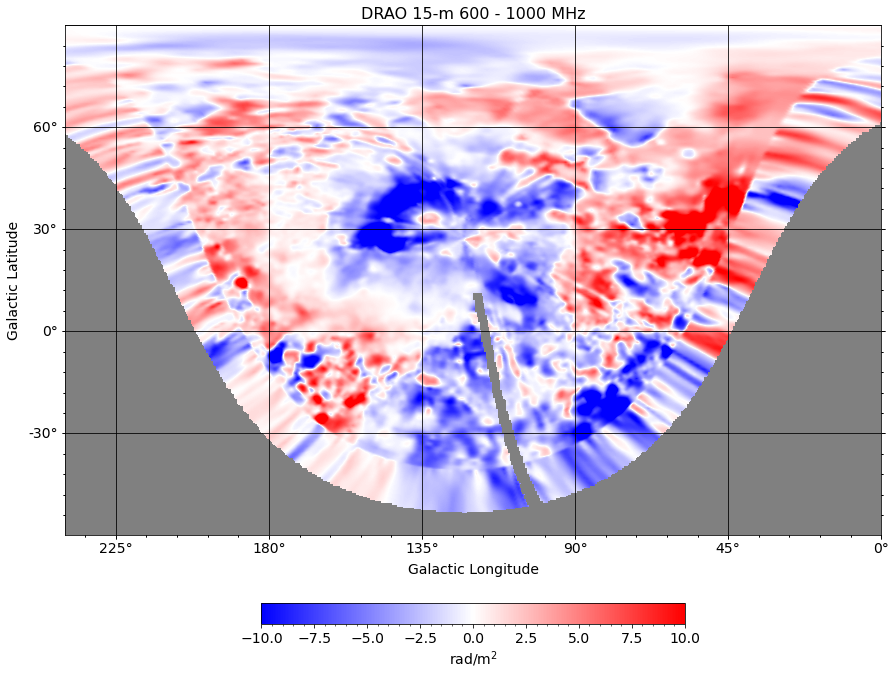

In [18]:
dlon = 120
loncent = 120

nice_map_zoom.platcar(M1_gal,'G',-10,10,pixsize=0.25,title=plot_title,
                 cmap = mpl.cm.get_cmap("bwr").copy(),bg_clr='gray',
                 xc=loncent,yc=0,grid_clr='black',axtitles=True,cbarlbl='rad/m$^2$',
                 lonra=[loncent-dlon,loncent+dlon],latra=[-60,90])
plt.tight_layout()
plt.savefig(dir_out+plot_name+'_M1.jpg')

## 3.5 Make M0 map

Plate Caree


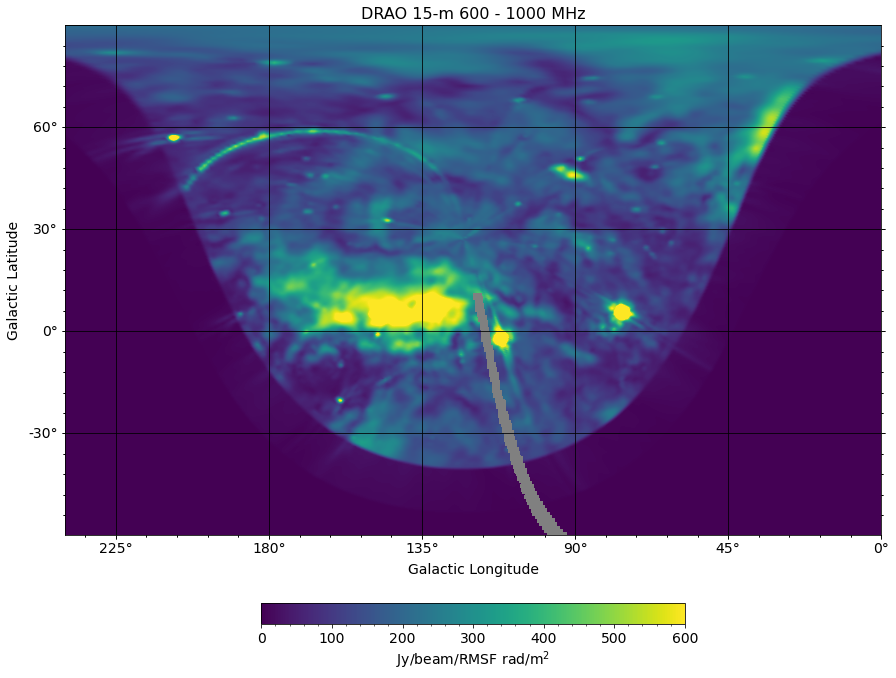

In [19]:
dlon = 120
loncent = 120

nice_map_zoom.platcar(M0_gal,'G',0,600,pixsize=0.25,title=plot_title,
                 cmap = mpl.cm.get_cmap("viridis").copy(),bg_clr='gray',
                 xc=loncent,yc=0,grid_clr='black',axtitles=True,cbarlbl='Jy/beam/RMSF rad/m$^2$',
                 lonra=[loncent-dlon,loncent+dlon],latra=[-60,90])
plt.tight_layout()
plt.savefig(dir_out+plot_name+'_M0.jpg')